In [4]:
# Standard library
import os
from argparse import ArgumentParser

# Third-party
import matplotlib
import matplotlib.pyplot as plt
import networkx
import numpy as np
import scipy.spatial
import skimage.draw
import torch
import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

### Funciones suplementarias:

In [5]:
def plot_graph(graph, title=None, graph_type=None):
    fig, axis = plt.subplots(figsize=(12, 6), dpi=300)  # W,H
    edge_index = graph.edge_index
    pos = graph.pos

    # Fix for re-indexed edge indices only containing mesh nodes at
    # higher levels in hierarchy
    edge_index = edge_index - edge_index.min()

    if pyg.utils.is_undirected(edge_index):
        # Keep only 1 direction of edge_index
        edge_index = edge_index[:, edge_index[0] < edge_index[1]]  # (2, M/2)
    # TODO: indicate direction of directed edges

    # Move all to cpu and numpy, compute (in)-degrees
    degrees = (
        pyg.utils.degree(edge_index[1], num_nodes=pos.shape[0]).cpu().numpy()
    )
    edge_index = edge_index.cpu().numpy()
    pos = pos.cpu().numpy()

    # Plot edges
    from_pos = pos[edge_index[0]]  # (M/2, 2)
    to_pos = pos[edge_index[1]]  # (M/2, 2)
    edge_lines = np.stack((from_pos, to_pos), axis=1)
    axis.add_collection(
        matplotlib.collections.LineCollection(
            edge_lines, lw=0.4, colors="black", zorder=1
        )
    )

    # Plot nodes
    node_scatter = axis.scatter(
        pos[:, 0],
        pos[:, 1],
        c=degrees,
        s=3,
        marker="o",
        zorder=2,
        cmap="viridis",
        clim=None,
    )

    plt.colorbar(node_scatter, aspect=50)

    if title is not None:
        axis.set_title(title)

    plt.savefig(os.path.join("figures", graph_type, f"{title}.png"))
    plt.close()


def sort_nodes_internally(nx_graph):
    # For some reason the networkx .nodes() return list can not be sorted,
    # but this is the ordering used by pyg when converting.
    # This function fixes this.
    H = networkx.DiGraph()
    H.add_nodes_from(sorted(nx_graph.nodes(data=True)))
    H.add_edges_from(nx_graph.edges(data=True))
    return H


def save_edges(graph, name, base_path):
    torch.save(
        graph.edge_index, os.path.join(base_path, f"{name}_edge_index.pt")
    )
    edge_features = torch.cat((graph.len.unsqueeze(1), graph.vdiff), dim=1).to(
        torch.float32
    )  # Save as float32
    torch.save(edge_features, os.path.join(base_path, f"{name}_features.pt"))


def save_edges_list(graphs, name, base_path):
    torch.save(
        [graph.edge_index for graph in graphs],
        os.path.join(base_path, f"{name}_edge_index.pt"),
    )
    edge_features = [
        torch.cat((graph.len.unsqueeze(1), graph.vdiff), dim=1).to(
            torch.float32
        )
        for graph in graphs
    ]  # Save as float32
    torch.save(edge_features, os.path.join(base_path, f"{name}_features.pt"))


def from_networkx_with_start_index(nx_graph, start_index):
    pyg_graph = from_networkx(nx_graph)
    pyg_graph.edge_index += start_index
    return pyg_graph


def crosses_land(node1, node2, land_mask, threshold=8):
    x1, y1 = node1
    x2, y2 = node2
    rr, cc = skimage.draw.line(round(y1), round(x1), round(y2), round(x2))
    return np.sum(land_mask[rr, cc]) >= threshold


def mk_2d_graph(xy, nx, ny, land_mask):
    xm, xM = np.amin(xy[0][0, :]), np.amax(xy[0][0, :])
    ym, yM = np.amin(xy[1][:, 0]), np.amax(xy[1][:, 0])

    # avoid nodes on border
    dx = (xM - xm) / nx
    dy = (yM - ym) / ny
    lx = np.linspace(xm + dx / 2, xM - dx / 2, nx, dtype=np.float32)
    ly = np.linspace(ym + dy / 2, yM - dy / 2, ny, dtype=np.float32)

    mg = np.meshgrid(lx, ly)
    g = networkx.grid_2d_graph(len(ly), len(lx))

    # kdtree for nearest neighbor search of land nodes
    land_points = np.argwhere(land_mask.T).astype(np.float32)
    land_kdtree = scipy.spatial.KDTree(land_points)

    # add nodes excluding land
    for node in list(g.nodes):
        node_pos = np.array([mg[0][node], mg[1][node]], dtype=np.float32)
        dist, _ = land_kdtree.query(node_pos, k=1)
        if dist < np.sqrt(0.5):
            g.remove_node(node)
        else:
            g.nodes[node]["pos"] = node_pos

    # add diagonal edges if both nodes exist
    for x in range(nx - 1):
        for y in range(ny - 1):
            if g.has_node((x, y)) and g.has_node((x + 1, y + 1)):
                g.add_edge((x, y), (x + 1, y + 1))
            if g.has_node((x + 1, y)) and g.has_node((x, y + 1)):
                g.add_edge((x + 1, y), (x, y + 1))

    # remove edges that goes across land
    for u, v in list(g.edges()):
        if crosses_land(g.nodes[u]["pos"], g.nodes[v]["pos"], land_mask):
            g.remove_edge(u, v)

    # turn into directed graph
    dg = networkx.DiGraph(g)

    # add node data
    for u, v in g.edges():
        d = np.sqrt(np.sum((g.nodes[u]["pos"] - g.nodes[v]["pos"]) ** 2))
        dg.edges[u, v]["len"] = d
        dg.edges[u, v]["vdiff"] = g.nodes[u]["pos"] - g.nodes[v]["pos"]
        dg.add_edge(v, u)
        dg.edges[v, u]["len"] = d
        dg.edges[v, u]["vdiff"] = g.nodes[v]["pos"] - g.nodes[u]["pos"]

    # add self edge if needed
    for v, degree in list(dg.degree()):
        if degree <= 1:
            dg.add_edge(v, v, len=0, vdiff=np.array([0, 0]))

    return dg


def prepend_node_index(graph, new_index):
    # Relabel node indices in graph, insert (graph_level, i, j)
    ijk = [tuple((new_index,) + x) for x in graph.nodes]
    to_mapping = dict(zip(graph.nodes, ijk))
    return networkx.relabel_nodes(graph, to_mapping, copy=True)

### Establecemos direcciones y valores simulando la entrada de datos de la terminal

In [6]:
plot = 0
dataset = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/data/atlantic"
graph_dir = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/graphs"
graph = "hierarchical"
figures_dir = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/figures"
levels_terminal = 3

### Carga de archivos necesarios

In [7]:
static_dir_path = os.path.join(dataset, "static")
graph_dir_path = os.path.join(graph_dir, graph)
os.makedirs(graph_dir_path, exist_ok=True)
if plot != 0:
    fig_dir_path = os.path.join(figures_dir, graph)
    os.makedirs(fig_dir_path, exist_ok=True)
xy = np.load(os.path.join(static_dir_path, "nwp_xy.npy"))
sea_mask = np.load(os.path.join(static_dir_path, "sea_mask.npy"))


land_mask = mascara de tierra \
grid_xy  = coordenadas de la cuadrícula \
pos_max = mayor valor absoluto presente en el tensor grid_xy (probable uso para normalización)

In [8]:
land_mask = ~sea_mask[0]
grid_xy = torch.tensor(xy)
pos_max = torch.max(torch.abs(grid_xy))

### Creación del Mesh:

In [9]:
nx = 3  # number of children = nx**2
nlev = int(np.log(max(xy.shape)) / np.log(nx))
nleaf = nx**nlev  # leaves at the bottom = nleaf**2
mesh_levels = nlev - 1
if levels_terminal is not None:
    mesh_levels = min(mesh_levels, levels_terminal)
    # Limit the levels in mesh graph
print(f"nlev: {nlev}, nleaf: {nleaf}, mesh_levels: {mesh_levels}")
# multi resolution tree levels
G = []
for lev in range(1, mesh_levels + 1):
    n = int(nleaf / (nx**lev))
    print(f"level {lev}, n: {n}")
    g = mk_2d_graph(xy, n, n, land_mask)
    if plot != 0:
        plot_graph(
            from_networkx(g),
            title=f"Mesh graph, level {lev}",
            graph_type=graph,
        )
    G.append(g)

nlev: 5, nleaf: 243, mesh_levels: 3
level 1, n: 81
level 2, n: 27
level 3, n: 9


Sabiendo los niveles que hay en la cuadrícula y los valores resultantes de n, podemos ver que los mesh tienen forma de:
- Primer nivel: 81*81
- Segundo nivel: 27*27
- Tercer nivel: 9*9

de donde podemos deducir que estos valores salen de, partiendo del valor de nleaf(243), dividiendo por 3 elevado a la potencia de la profundidad del mesh.

Este 243 sale del resultado de 3^5, donde 5 es la profundidad máxima que puede tener el mesh dada la forma de nuestro grid y la cantidad de hijos (nx) establecido en el código.

Los niveles se hacen a base de potencias del valor asignado de nx, donde el valor de nleaf también es dependiente de nx.

A priori, dicho valor de nx = 3 puede estar asociado también a la heurística de que, en las CNN, el kernel de convolución suele ser un 3*3, por lo que se puede pensar que se está tratando de emular un kernel de convolución en el mesh. Aunque esto es una suposición.

In [10]:
print("Cantidad de niveles del mesh: ", len(G))
print("Número de nodos del primer nivel: ", len(G[0]))
print("número de nodos del segundo nivel: ", len(G[1]))
print("número de nodos del tercer nivel: ", len(G[2]))

print(len(G[0]))
for i in range(len(G)):
    #ver cada elemento de G
    print(G[i])
    #ver el primer elemento de G
    print(G[i].nodes)
    print(G[i].edges)

Cantidad de niveles del mesh:  3
Número de nodos del primer nivel:  3568
número de nodos del segundo nivel:  394
número de nodos del tercer nivel:  45
3568
DiGraph with 3568 nodes and 27578 edges
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18

## Parte del Hierarchical Mesh

En la primera parte se le añade una nueva dimensión a los nodos de los diferentes grafos del mesh de forma que se pueden identificar los nodos de los diferentes niveles.

In [11]:
# Relabel nodes of each level with level index first
G = [
    prepend_node_index(graph, level_i)
    for level_i, graph in enumerate(G)
]

num_nodes_level = np.array([len(g_level.nodes) for g_level in G])
# First node index in each level in the hierarchical graph
first_index_level = np.concatenate(
    (np.zeros(1, dtype=int), np.cumsum(num_nodes_level[:-1]))
)


In [12]:
print("Número de nodos por nivel: ", num_nodes_level)
print("Primer nodo de cada nivel: ", first_index_level)

Número de nodos por nivel:  [3568  394   45]
Primer nodo de cada nivel:  [   0 3568 3962]


En esta parte, teniendo el total de nodos del mesh (suma de los 3 niveles en nuestro caso), generamos los indices iniciales de cada nivel, de forma que posteriormente se puedan concatenar los nodos de los diferentes niveles al establecer estos indices, preparando también de esta manera los "identificadores" de los nodos para que la transformación a formato PyG sea exitosa.

<a id="ExplicacionGrafosMesh"></a>
### Explicación contenido de los niveles de mesh 

En este momento, para el mesh tenemos 3 grafos de 81x81, 27x27 y 9x9 nodos respectivamente, donde cada nodo está conectado con 4 vecinos donde existe la posibilidad de nodos con menos conexiones al eliminar aristas que coincidan con zonas terrestres y donde además, si existe la posibilidad en base a la existencia de nodos en la diagonal, se pueden conectar con 8 vecinos. (la escala de colores de las imágenes está mal, parece que distingue entre aristas generadas manualmente y aristas generadas por networkx para la visualización).



In [13]:
for i in range(len(G)):
    print(len(G[i]))
    #ver cada elemento de G
    print(G[i])
    #ver el primer elemento de G
    print(G[i].nodes)

3568
DiGraph with 3568 nodes and 27578 edges
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 0, 11), (0, 0, 12), (0, 0, 13), (0, 0, 14), (0, 0, 15), (0, 0, 16), (0, 0, 17), (0, 0, 18), (0, 0, 19), (0, 0, 20), (0, 0, 21), (0, 0, 22), (0, 0, 23), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 1, 11), (0, 1, 12), (0, 1, 13), (0, 1, 14), (0, 1, 15), (0, 1, 16), (0, 1, 17), (0, 1, 18), (0, 1, 19), (0, 1, 20), (0, 1, 21), (0, 1, 22), (0, 1, 23), (0, 1, 24), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 2, 10), (0, 2, 11), (0, 2, 12), (0, 2, 13), (0, 2, 14), (0, 2, 15), (0, 2, 16), (0, 2, 17), (0, 2, 18), (0, 2, 19), (0, 2, 20), (0, 2, 21), (0, 2, 22), (0, 2, 23), (0, 2, 24), (0, 2, 25), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 

Se le ha añadido a nivel del mesh una nueva coordenada (dimensión) correspondiente al nivel al que pertenece el nodo, de forma que se pueda identificar a qué nivel pertenece cada nodo posteriormente.

En la parte próxima se crean las aristas que comunican los diferentes niveles del mesh entre sí, de forma que se quede la siguiente estructura:

--Grid--\
--G2M--\
--Mesh_lvl1--\
--Mesh_up_2_1-- y Mesh_down_1_2\
--Mesh_lvl2--\
--Mesh_up_3_2-- y Mesh_down_2_3\
--Mesh_lvl3--\
--M2G--\
--Grid--

En la siguiente parte del código se crean los mesh_up y los mesh_down

In [14]:
# Create inter-level mesh edges
up_graphs = []
down_graphs = []
for from_level, to_level, G_from, G_to, start_index in zip(
    range(1, mesh_levels),
    range(0, mesh_levels - 1),
    G[1:],
    G[:-1],
    first_index_level[: mesh_levels - 1],
):
    # start out from graph at from level
    G_down = G_from.copy()
    G_down.clear_edges()
    G_down = networkx.DiGraph(G_down)
    # Add nodes of to level
    G_down.add_nodes_from(G_to.nodes(data=True))
    # build kd tree for mesh point pos
    # order in vm should be same as in vm_xy
    v_to_list = list(G_to.nodes)
    v_from_list = list(G_from.nodes)
    v_from_xy = np.array([xy for _, xy in G_from.nodes.data("pos")])
    kdt_m = scipy.spatial.KDTree(v_from_xy)
    # add edges from mesh to grid
    for v in v_to_list:
        # find k nearest neighbours (index to vm_xy)
        neigh_idx = kdt_m.query(G_down.nodes[v]["pos"], k=16)[1]
        for idx in neigh_idx:
            u = v_from_list[idx]
            # add edge from mesh to grid
            if not crosses_land(
                G_down.nodes[u]["pos"],
                G_down.nodes[v]["pos"],
                land_mask,
            ):
                G_down.add_edge(u, v)
                d = np.sqrt(
                    np.sum(
                        (
                            G_down.nodes[u]["pos"]
                            - G_down.nodes[v]["pos"]
                        )
                        ** 2
                    )
                )
                G_down.edges[u, v]["len"] = d
                G_down.edges[u, v]["vdiff"] = (
                    G_down.nodes[u]["pos"] - G_down.nodes[v]["pos"]
                )
                break
    # relabel nodes to integers (sorted)
    G_down_int = networkx.convert_node_labels_to_integers(
        G_down, first_label=start_index, ordering="sorted"
    )  # Issue with sorting here
    G_down_int = sort_nodes_internally(G_down_int)
    pyg_down = from_networkx_with_start_index(G_down_int, start_index)
        # Create up graph, invert downwards edges
    up_edges = torch.stack(
            (pyg_down.edge_index[1], pyg_down.edge_index[0]), dim=0
        )
    pyg_up = pyg_down.clone()
    pyg_up.edge_index = up_edges
    up_graphs.append(pyg_up)
    down_graphs.append(pyg_down)
    if plot != 0:
        plot_graph(
            pyg_down,
            title=f"Down graph, {from_level}_{to_level}",
            graph_type=graph,
        )
        plot_graph(
            pyg_down,
            title=f"Up graph, {to_level}_{from_level}",
            graph_type=graph,
        )

# Save up and down edges
save_edges_list(up_graphs, "mesh_up", graph_dir_path)
save_edges_list(down_graphs, "mesh_down", graph_dir_path)



c:\Users\Gabri\anaconda3\envs\tfg_env\lib\site-packages\torch_geometric\utils\convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  data_dict[key] = torch.as_tensor(value)


### Explicación de la creación de los mesh_up y mesh_down
Los grafos del mesh down se generan de la siguiente manera:
- Se crea un nuevo grafo con el mismo número de nodos que el grafo desde el que se parte (el inferior de mayor cantidad de nodos)
- Se eliminan todas las aristas que tuviese el grafo original
- Se crean nuevas aristas que van dirigidos desde los nodos del grafo inferior a los nodos del grafo inferior en donde:
    - para cada nodo del grafo inferior, se buscan los k (en este caso es igual a 16) nodos más cercanos del grafo inferior.
    - Se verifica que no cruce la máscara de tierra, en cuyo caso no se añadiría la arista.
    - Se calcula la distancia euclídia entre los nodos y se añade como variable "len"
    - Se calcula la distancia vectorial (se resta la posición de 1 nodo respecto a otro) y se añade como variable "vdiff" (no absoluto?)
- Se transforman las etiquetas de los nodos para que sean enteros y se ordenan de menor a mayor según la etiqueta establecida por networkx
- Se invierten las aristas para que vayan desde el grafo superior al inferior, siendo el mesh up un clon del mesh down pero con las aristas invertidas.
Se transforman ambos grafos a formato PyG. y se guardan los edge_index en un archivo .pt y las características(features) de los nodos en otro archivo .pt, donde las características son graph.len.unsqueeze(1), graph.vdiff, es decir, la distancia euclídea y la distancia vectorial respectivamente en ambas dimensiones.

In [15]:
print("---Contenido del G_down: ")
print(G_down)
print(G_down.nodes)

print("\n---Contenido del G_down_int: ")
print(G_down_int)
print(G_down_int.nodes)

print("\n---Contenido del pyg_down: ")
print(pyg_down)

print("\n---Contenido del pyg_up: ")
print(pyg_up)

print("\n---Contenido del up_graphs: ")
print(up_graphs)
for pyg_up in up_graphs:
    print(pyg_up)
    print("el primer indice del edge_index (sender):", pyg_up.edge_index[0][:10])
    print("el segundo indice del edge_index (receiver):", pyg_up.edge_index[1][:10])
    print("el len (distancia euclídea):", pyg_up.len[:10])
    print("el vdiff (distancia vectorial):", pyg_up.vdiff[:10])
    print("el pos(posicion de los nodos (creo)):", pyg_up.pos[:10])


print("\n---Contenido del down_graphs: ")
print(down_graphs)
for pyg_down in down_graphs:
    print(pyg_down)
    print("el primer indice del edge_index (sender):", pyg_down.edge_index[0][:10])
    print("el segundo indice del edge_index (receiver):", pyg_down.edge_index[1][:10])
    print("el len (distancia euclídea):", pyg_down.len[:10])
    print("el vdiff (distancia vectorial):", pyg_down.vdiff[:10])
    print("el pos(posicion de los nodos (creo)):", pyg_down.pos[:10])



---Contenido del G_down: 
DiGraph with 439 nodes and 394 edges
[(2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 4, 0), (2, 4, 1), (2, 4, 2), (2, 4, 3), (2, 4, 4), (2, 5, 0), (2, 5, 1), (2, 5, 2), (2, 5, 3), (2, 5, 4), (2, 5, 5), (2, 6, 0), (2, 6, 1), (2, 6, 2), (2, 6, 3), (2, 6, 4), (2, 6, 5), (2, 6, 6), (2, 7, 0), (2, 7, 1), (2, 7, 2), (2, 7, 3), (2, 7, 4), (2, 7, 5), (2, 7, 6), (2, 8, 0), (2, 8, 1), (2, 8, 2), (2, 8, 3), (2, 8, 4), (2, 8, 5), (2, 8, 6), (2, 8, 7), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (1, 0, 6), (1, 0, 7), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 1, 6), (1, 1, 7), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (1, 3, 4), (1, 3, 5), (1, 3, 6), (1, 4, 0), (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5), (1, 4, 6), (1, 5, 0), (1, 5, 1), (1, 5, 2), (

## Parte del mesh correspondiente al modelo más similar a Graphcast

Presenta problemas con el reshape para la creación de los grafos, se debe revisar esta parte si se quiere implementar un modelo de grafos similar a Graphcast. Por el momento no se explicará en detalle hasta que se tome una decisión definitiva de implementar esta variable.

## Continuación de la creación del mesh común a todos los modelos.

Se genera una lista de grafos de PyG con los grafos de los diferentes niveles del mesh (para posterior referencia la llamaremos "lista m2m")

A partir de esta lista de grafos en formato PyG, se obtienen las posiciones de los nodos en una lista de listas n_elementos correspondientes a la cantidad de nodos que hay en cada nivel de los diferentes niveles del mesh.

Para la posterior generación del G2M Y M2G, guardamos el primer nivel del mesh en una variable (el de mayor cantidad de nodos) y guardamos un grafo resultado de la unión de todos los niveles del mesh y en otra variable guardamos los nodos de este nuevo grafo junto con los datos de los  nodos.

Tras estos pasos, se guarda la "lista m2m" al formato PyG.

### Grid2Mesh

In [16]:
# Save m2m edges
        # Extract intra-level edges for m2m
m2m_graphs = [
    from_networkx_with_start_index(
        networkx.convert_node_labels_to_integers(
            level_graph, first_label=start_index, ordering="sorted"
        ),
        start_index,
    )
    for level_graph, start_index in zip(G, first_index_level)
]

mesh_pos = [graph.pos.to(torch.float32) for graph in m2m_graphs]
# For use in g2m and m2g
G_bottom_mesh = G[0]
joint_mesh_graph = networkx.union_all([graph for graph in G])
all_mesh_nodes = joint_mesh_graph.nodes(data=True)

save_edges_list(m2m_graphs, "m2m", graph_dir_path)

# Divide mesh node pos by max coordinate of grid cell
mesh_pos = [pos / pos_max for pos in mesh_pos]

# Save mesh positions
torch.save(
    mesh_pos, os.path.join(graph_dir_path, "mesh_features.pt")
)  # mesh pos, in float32

Como "mesh_features" se guardan las "posiciones relativas" de los nodos del mesh (de todos los nodos de todos los niveles). Nos referimos a posiciones relativas debido a que se toma cada posición de los nodos y se divide por el mayor valor de posición en el mesh, de forma que se normalizan las posiciones de los nodos en el mesh.

In [17]:
print("\n---Contenido del m2m_graphs: ")
print(m2m_graphs)

print("\n---Contenido del mesh_pos: ")
print("número de listas del mes_pos", len(mesh_pos))
for i in range(len(mesh_pos)):
    print(f"cantidad de valores en la lista numero {i} del mesh_pos: ", len(mesh_pos[i]))
    print(f"valor de ejemplo de la lista {i}: " , mesh_pos[i][1])

print("\n---Contenido del G_bottom_mesh (primera cada de la lista de grafos de mesh): ")
print(G_bottom_mesh)
print(G_bottom_mesh.nodes)

print("\n---Contenido del joint_mesh_graph: ")
print(joint_mesh_graph)
print(joint_mesh_graph.nodes)
print("Total de nodos entre todas las capas: 3568 + 394 + 45 = ", 3568 + 394 + 45)

print("\n---Contenido del all_mesh_nodes: ")
print(all_mesh_nodes)



---Contenido del m2m_graphs: 
[Data(edge_index=[2, 27578], pos=[3568, 2], len=[27578], vdiff=[27578, 2]), Data(edge_index=[2, 2848], pos=[394, 2], len=[2848], vdiff=[2848, 2]), Data(edge_index=[2, 268], pos=[45, 2], len=[268], vdiff=[268, 2])]

---Contenido del mesh_pos: 
número de listas del mes_pos 3
cantidad de valores en la lista numero 0 del mesh_pos:  3568
valor de ejemplo de la lista 0:  tensor([0.0185, 0.0062])
cantidad de valores en la lista numero 1 del mesh_pos:  394
valor de ejemplo de la lista 1:  tensor([0.0556, 0.0185])
cantidad de valores en la lista numero 2 del mesh_pos:  45
valor de ejemplo de la lista 2:  tensor([0.1667, 0.0556])

---Contenido del G_bottom_mesh (primera cada de la lista de grafos de mesh): 
DiGraph with 3568 nodes and 27578 edges
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 0, 11), (0, 0, 12), (0, 0, 13), (0, 0, 14), (0, 0, 15), (0, 0, 16), (0, 0, 17), (0, 0, 18), (0,

In [18]:
print(len(mesh_pos))
for i in range(len(mesh_pos)):
    print(len(mesh_pos[i]))
    print(mesh_pos[i][1])
    #valor minimos y maximos de las posiciones
    print("Valor minimo de la posición: ", torch.min(mesh_pos[i]))
    print("Valor maximo de la posición: ", torch.max(mesh_pos[i]))

3
3568
tensor([0.0185, 0.0062])
Valor minimo de la posición:  tensor(0.0062)
Valor maximo de la posición:  tensor(0.9938)
394
tensor([0.0556, 0.0185])
Valor minimo de la posición:  tensor(0.0185)
Valor maximo de la posición:  tensor(0.9815)
45
tensor([0.1667, 0.0556])
Valor minimo de la posición:  tensor(0.0556)
Valor maximo de la posición:  tensor(0.9444)


In [19]:
# radius within which grid nodes are associated with a mesh node
# (in terms of mesh distance)
DM_SCALE = 0.67

# mesh nodes on lowest level
vm = G_bottom_mesh.nodes
vm_xy = np.array([xy for _, xy in vm.data("pos")])

In [20]:
print(len(vm))
print(vm)
print(len(vm_xy))
print(vm_xy[1])

3568
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 0, 11), (0, 0, 12), (0, 0, 13), (0, 0, 14), (0, 0, 15), (0, 0, 16), (0, 0, 17), (0, 0, 18), (0, 0, 19), (0, 0, 20), (0, 0, 21), (0, 0, 22), (0, 0, 23), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 1, 11), (0, 1, 12), (0, 1, 13), (0, 1, 14), (0, 1, 15), (0, 1, 16), (0, 1, 17), (0, 1, 18), (0, 1, 19), (0, 1, 20), (0, 1, 21), (0, 1, 22), (0, 1, 23), (0, 1, 24), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 2, 10), (0, 2, 11), (0, 2, 12), (0, 2, 13), (0, 2, 14), (0, 2, 15), (0, 2, 16), (0, 2, 17), (0, 2, 18), (0, 2, 19), (0, 2, 20), (0, 2, 21), (0, 2, 22), (0, 2, 23), (0, 2, 24), (0, 2, 25), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 3, 8), (0, 3, 9), (0, 3, 10), (0

vm_xy guarda las posiciones de los nodos del primer nivel (el de mayor cantidad de nodos dentro del mesh)

In [21]:
# fin consecutive nodes on the same row

# Se crea un diccionario 'vm_pos' que mapea cada clave a su posición,
# utilizando los datos obtenidos de vm.data("pos")
vm_pos = {key: pos for key, pos in vm.data("pos")}

# Se ordenan las claves de 'vm_pos' de forma ascendente basándose en sus tres componentes (k[0], k[1], k[2])
sorted_keys = sorted(vm_pos.keys(), key=lambda k: (k[0], k[1], k[2]))

# Inicializamos key1 y key2 en None; se usarán para almacenar la primera pareja de claves que cumpla las condiciones
key1, key2 = None, None

# Iteramos sobre las claves ordenadas hasta el penúltimo elemento
for i in range(len(sorted_keys) - 1):
    # Obtenemos dos claves consecutivas: k1 es la clave actual y k2 es la siguiente en la lista
    k1, k2 = sorted_keys[i], sorted_keys[i + 1]
    
    # Verificamos que las dos claves tengan iguales los dos primeros elementos
    # y que el tercer elemento de k2 sea exactamente una unidad mayor que el de k1
    if k1[0] == k2[0] and k1[1] == k2[1] and k1[2] + 1 == k2[2]:
        # Se comprueba que la segunda componente de la posición asociada a k1 sea igual a la de k2
        if np.array_equal(vm_pos[k1][1], vm_pos[k2][1]):
            # Si ambas condiciones se cumplen, asignamos k1 y k2 a key1 y key2 respectivamente
            key1, key2 = k1, k2
            # Se sale del bucle tras encontrar la primera pareja que cumple la condición
            break


Este bucle se encarga de encontrar un par de nodos en el mesh consecutivos que estén conectados por una arista y que no estén conectados por una arista en el grid, de forma que se pueda calcular un valor de distancia euclídea fija entre los nodos del mesh.

In [22]:
print(key1, key2)

(0, 0, 0) (0, 0, 1)


In [23]:
# distance between mesh nodes
dm = np.sqrt(np.sum((vm.data("pos")[key1] - vm.data("pos")[key2]) ** 2))


In [24]:
print("Distancia entre nodos de la malla: ", dm)

Distancia entre nodos de la malla:  3.6913579


In [25]:
# grid nodes
Ny, Nx = xy.shape[1:]
print(Ny, Nx)

300 300


In [26]:
G_grid = networkx.grid_2d_graph(Ny, Nx)
G_grid.clear_edges()

# vg features (only pos introduced here)
nodes_to_remove = []
for node in G_grid.nodes:
    # Remove the node from the graph if it is a land node
    if land_mask[node[0], node[1]]:
        nodes_to_remove.append(node)
    else:
        # pos is in feature but here explicit for convenience
        G_grid.nodes[node]["pos"] = np.array([xy[0][node], xy[1][node]])

for node in nodes_to_remove:
    G_grid.remove_node(node)


In [27]:
print(G_grid.nodes)
#ver el pos de los nodos
#for node in G_grid.nodes:
#    print(G_grid.nodes[node]["pos"])

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1

In [28]:
# add 1000 to node key to separate grid nodes (1000,i,j) from mesh nodes
# (i,j) and impose sorting order such that vm are the first nodes
G_grid = prepend_node_index(G_grid, 1000)


In [29]:
print(G_grid)

Graph with 49061 nodes and 0 edges


In [30]:
# build kd tree for grid point pos
# order in vg_list should be same as in vg_xy
vg_list = list(G_grid.nodes)
vg_xy = np.array([[xy[0][node[1:]], xy[1][node[1:]]] for node in vg_list])
kdt_g = scipy.spatial.KDTree(vg_xy)

Se le añade el 1000 para que no se emplee el indice de la profundidad en el grid /
vg_xy parece una lista de vecinos

In [31]:
print(vg_list)
print(vg_xy)

[(1000, 0, 0), (1000, 0, 1), (1000, 0, 2), (1000, 0, 3), (1000, 0, 4), (1000, 0, 5), (1000, 0, 6), (1000, 0, 7), (1000, 0, 8), (1000, 0, 9), (1000, 0, 10), (1000, 0, 11), (1000, 0, 12), (1000, 0, 13), (1000, 0, 14), (1000, 0, 15), (1000, 0, 16), (1000, 0, 17), (1000, 0, 18), (1000, 0, 19), (1000, 0, 20), (1000, 0, 21), (1000, 0, 22), (1000, 0, 23), (1000, 0, 24), (1000, 0, 25), (1000, 0, 26), (1000, 0, 27), (1000, 0, 28), (1000, 0, 29), (1000, 0, 30), (1000, 0, 31), (1000, 0, 32), (1000, 0, 33), (1000, 0, 34), (1000, 0, 35), (1000, 0, 36), (1000, 0, 37), (1000, 0, 38), (1000, 0, 39), (1000, 0, 40), (1000, 0, 41), (1000, 0, 42), (1000, 0, 43), (1000, 0, 44), (1000, 0, 45), (1000, 0, 46), (1000, 0, 47), (1000, 0, 48), (1000, 0, 49), (1000, 0, 50), (1000, 0, 51), (1000, 0, 52), (1000, 0, 53), (1000, 0, 54), (1000, 0, 55), (1000, 0, 56), (1000, 0, 57), (1000, 0, 58), (1000, 0, 59), (1000, 0, 60), (1000, 0, 61), (1000, 0, 62), (1000, 0, 63), (1000, 0, 64), (1000, 0, 65), (1000, 0, 66), (100

In [32]:
# now add (all) mesh nodes, include features (pos)
G_grid.add_nodes_from(all_mesh_nodes)


In [33]:
print(G_grid)

Graph with 53068 nodes and 0 edges


In [34]:
# Re-create graph with sorted node indices
# Need to do sorting of nodes this way for indices to map correctly to pyg
G_g2m = networkx.Graph()
G_g2m.add_nodes_from(sorted(G_grid.nodes(data=True)))

# turn into directed graph
G_g2m = networkx.DiGraph(G_g2m)

In [35]:
print(G_g2m)

DiGraph with 53068 nodes and 0 edges


In [36]:
# add edges
for v in vm:
    # find neighbours (index to vg_xy)
    neigh_idxs = kdt_g.query_ball_point(vm[v]["pos"], dm * DM_SCALE)
    for i in neigh_idxs:
        u = vg_list[i]
        # add edge from grid to mesh
        G_g2m.add_edge(u, v)
        d = np.sqrt(
            np.sum((G_g2m.nodes[u]["pos"] - G_g2m.nodes[v]["pos"]) ** 2)
        )
        G_g2m.edges[u, v]["len"] = d
        G_g2m.edges[u, v]["vdiff"] = (
            G_g2m.nodes[u]["pos"] - G_g2m.nodes[v]["pos"]
        )


In [37]:
print(G_g2m)
print(G_g2m.nodes)

DiGraph with 53068 nodes and 68206 edges
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 0, 11), (0, 0, 12), (0, 0, 13), (0, 0, 14), (0, 0, 15), (0, 0, 16), (0, 0, 17), (0, 0, 18), (0, 0, 19), (0, 0, 20), (0, 0, 21), (0, 0, 22), (0, 0, 23), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 1, 11), (0, 1, 12), (0, 1, 13), (0, 1, 14), (0, 1, 15), (0, 1, 16), (0, 1, 17), (0, 1, 18), (0, 1, 19), (0, 1, 20), (0, 1, 21), (0, 1, 22), (0, 1, 23), (0, 1, 24), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 2, 10), (0, 2, 11), (0, 2, 12), (0, 2, 13), (0, 2, 14), (0, 2, 15), (0, 2, 16), (0, 2, 17), (0, 2, 18), (0, 2, 19), (0, 2, 20), (0, 2, 21), (0, 2, 22), (0, 2, 23), (0, 2, 24), (0, 2, 25), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), 

In [38]:
from collections import Counter

def compute_metrics_from_graph(graph):
    """
    Calcula métricas de conexión para un grafo de NetworkX.

    Se asume que las etiquetas de los nodos son tuplas del tipo (tipo, x, y),
    donde:
      - Los nodos de malla tienen 'tipo' igual a 0.
      - Los nodos de grilla tienen 'tipo' igual a 1000.

    Las métricas calculadas para cada grupo son:
      - min_degree: grado mínimo.
      - max_degree: grado máximo.
      - average_degree: grado promedio.
      - count_degrees: distribución (frecuencia) de los grados.

    Retorna:
      Una tupla (grid_metrics, mesh_metrics), donde cada métrica es un diccionario.
    """
    grid_degrees = []
    mesh_degrees = []
    
    # Recorrer cada nodo del grafo y clasificar según el primer elemento de la tupla.
    for node in graph.nodes():
        degree = graph.degree[node]
        if isinstance(node, tuple) and len(node) >= 1:
            if node[0] == 1000:
                grid_degrees.append(degree)
            elif node[0] == 0:
                mesh_degrees.append(degree)

    def compute_metrics(degree_list):
        if not degree_list:
            return {
                "min_degree": None,
                "max_degree": None,
                "average_degree": None,
                "count_degrees": {}
            }
        counter = Counter(degree_list)
        return {
            "min_degree": min(degree_list),
            "max_degree": max(degree_list),
            "average_degree": sum(degree_list) / len(degree_list),
            "count_degrees": dict(counter)
        }
    
    grid_metrics = compute_metrics(grid_degrees)
    mesh_metrics = compute_metrics(mesh_degrees)
    
    return grid_metrics, mesh_metrics


In [39]:
grid_metrics, mesh_metrics = compute_metrics_from_graph(G_g2m)
print("Métricas de conexión para nodos de grilla:")
#print grid_metrics without last element
for key, value in grid_metrics.items():
    if key != "count_degrees":
        print(f"{key}: {value}")
if "count_degrees" in grid_metrics:
    print("Distribución de grados:")
    for degree, count in sorted(grid_metrics["count_degrees"].items()):
        print(f"Grado {degree}: {count} nodos")
        
print("-----------------------")
print("Métricas de conexión para nodos de malla:")
for key, value in mesh_metrics.items():
    if key != "count_degrees":
        print(f"{key}: {value}")
if "count_degrees" in mesh_metrics:
    print("Distribución de grados:")
    for degree, count in sorted(mesh_metrics["count_degrees"].items()):
        print(f"Grado {degree}: {count} nodos")

Métricas de conexión para nodos de grilla:
min_degree: 0
max_degree: 2
average_degree: 1.3902284910621472
Distribución de grados:
Grado 0: 480 nodos
Grado 1: 28956 nodos
Grado 2: 19625 nodos
-----------------------
Métricas de conexión para nodos de malla:
min_degree: 7
max_degree: 21
average_degree: 19.11603139013453
Distribución de grados:
Grado 7: 1 nodos
Grado 10: 3 nodos
Grado 11: 5 nodos
Grado 12: 6 nodos
Grado 13: 7 nodos
Grado 14: 10 nodos
Grado 15: 11 nodos
Grado 16: 103 nodos
Grado 17: 52 nodos
Grado 18: 773 nodos
Grado 19: 1389 nodos
Grado 20: 559 nodos
Grado 21: 649 nodos


Como podemos ver, hay nodos de la grilla (Grid) que no tienen conexiones con nodos del mesh, lo que puede ser un problema de implementación donde parece que la vía creada por GraphCast podría no ser la más adecuada para nuestro dominio y estructura de grafos. Se plantearán soluciones alternativas en el futuro.

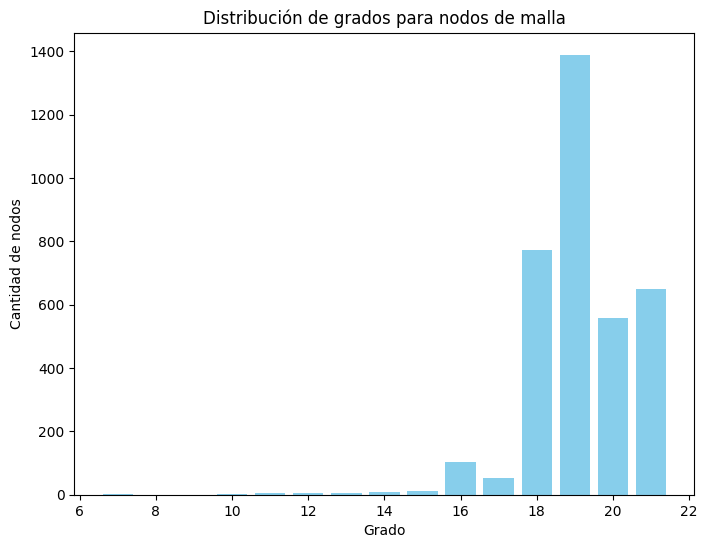

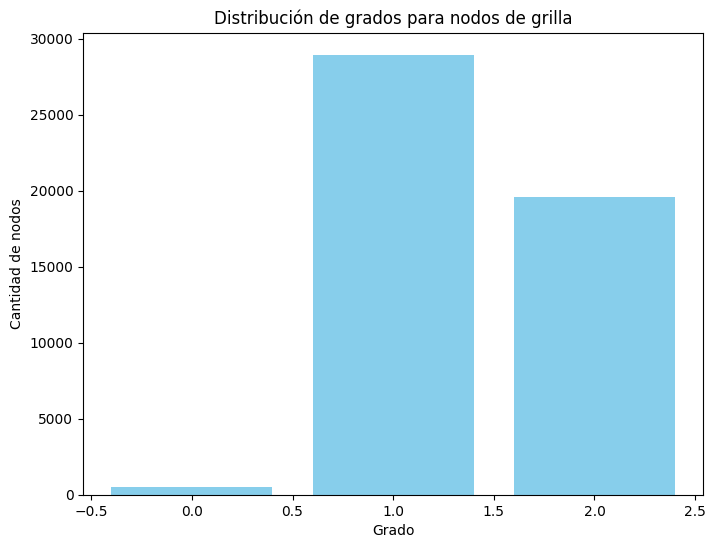

In [40]:
def plot_degree_distribution(degree_counter, title):
    """
    Grafica la distribución de grados a partir de un contador de grados.

    Parámetros:
      - degree_counter: Counter
          Contador de grados.
      - title: str
          Título del gráfico.
    """
    degrees, counts = zip(*sorted(degree_counter.items()))
    plt.figure(figsize=(8, 6))
    plt.bar(degrees, counts, color='skyblue')
    plt.xlabel("Grado")
    plt.ylabel("Cantidad de nodos")

    if title is not None:
        plt.title(title)
    
    #show graph
    plt.show()
    
    plt.close()
plot_degree_distribution(mesh_metrics["count_degrees"], "Distribución de grados para nodos de malla")
plot_degree_distribution(grid_metrics["count_degrees"], "Distribución de grados para nodos de grilla")


Se transforma el mesh en un grafo de Pytorch Geometric

In [35]:
pyg_g2m = from_networkx(G_g2m)

if plot != 0:
    pyg_g2m_reversed = pyg_g2m.clone()
    pyg_g2m_reversed.edge_index = pyg_g2m.edge_index[[1, 0]]
    plot_graph(
        pyg_g2m_reversed, title="Grid-to-mesh", graph_type=graph
    )


In [36]:
print(pyg_g2m)

Data(edge_index=[2, 68106], pos=[51434, 2], len=[68106], vdiff=[68106, 2])


### Explicación del G2M y M2G

**Para el G2m:**
- Se establece el DM_SCALE como 0.67, que será un valor el cuál definirá el radio dentro del cual los nodos del Grid estarán asociados con un nodo de del mesh de primer nivel (nivel con más nodos).
-  A través de las posiciones de los nodos en el primer nivel del mesh, se halla un valor de distancia euclídea entre nodos ya que, al ser el mesh uniforme, la distancia entre nodos se mantendrá constante.
- Una vez obtenida esta distancia euclídea, pasaremos a crear un nuevo grafo, donde partiremos de las dimensiones del Grid y donde eliminamos todos aquellos nodos que estén en la máscara de tierra.
Se hace un kdtree para obtener nodos vecinos, haciendo este proceso solo con los nodos del grid, ya que, posteriormente, se añaden todos los nodos del mesh (de todos los niveles) dentro del nuevo grafo que se está generando y se ordenan de menor a mayor según la etiqueta establecida por networkx.
- Se buscan todos los vecinos que se encuentren en un radio de distancia establecido por la distancia entre nodos del mesh calculada anteriormente por el factor DM_SCALE y se añaden las aristas correspondientes así como la distancia euclídea entre los nodos y la distancia vectorial entre los nodos.
- Se transforma el grafo a formato PyG y se guardan las características de los nodos en un archivo .pt

**Para el M2G:**
- Se crea un nuevo grafo copia del grafo G2M para obtener el mismo número de nodos, pero se borran las aristas.
- En este caso, el kdtree se hace con las posiciones de los nodos del mesh de primer nivel, en este caso, cada nodo del Grid se conectará con los 4 nodos más cercanos del mesh.
- Posteriormente se ponen las etiquetas de los nodos como enteros y se transforma el grafo a formato PyG.

Se guardan los grafos en formato PyG.



### Mesh2Grid


In [37]:
# start out from Grid2Mesh and then replace edges
G_m2g = G_g2m.copy()
G_m2g.clear_edges()


In [38]:
print(G_m2g)

DiGraph with 51434 nodes and 0 edges


In [ ]:
# build kd tree for mesh point pos
# order in vm should be same as in vm_xy
vm_list = list(vm)
kdt_m = scipy.spatial.KDTree(vm_xy)

Se mantienen los mismos vecinos que en el G_g2m

In [40]:
print(vm_list)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 0, 11), (0, 0, 12), (0, 0, 13), (0, 0, 14), (0, 0, 15), (0, 0, 16), (0, 0, 17), (0, 0, 18), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 1, 11), (0, 1, 12), (0, 1, 13), (0, 1, 14), (0, 1, 15), (0, 1, 16), (0, 1, 17), (0, 1, 18), (0, 1, 19), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 2, 10), (0, 2, 11), (0, 2, 12), (0, 2, 13), (0, 2, 14), (0, 2, 15), (0, 2, 16), (0, 2, 17), (0, 2, 18), (0, 2, 19), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 3, 8), (0, 3, 9), (0, 3, 10), (0, 3, 11), (0, 3, 12), (0, 3, 13), (0, 3, 14), (0, 3, 15), (0, 3, 16), (0, 3, 17), (0, 3, 18), (0, 3, 19), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4), (0, 4, 5), (0, 4, 6), (0, 4, 7), (0,

Para el mesh2grid e toman los 4 vecinos más cercanos, mientras que en el grid2mesh se toman los kdt_g.query_ball_point(vm[v]["pos"], dm * DM_SCALE) vecinos, donde el número de vecinos es variable dependiendo de la distancia obtenida en "dm" de nodos consecutivos en la misma fila.

In [41]:
# add edges from mesh to grid
for v in vg_list:
    # find 4 nearest neighbours (index to vm_xy)
    neigh_idxs = kdt_m.query(G_m2g.nodes[v]["pos"], 4)[1]
    for i in neigh_idxs:
        u = vm_list[i]
        d = np.sqrt(
            np.sum((G_m2g.nodes[u]["pos"] - G_m2g.nodes[v]["pos"]) ** 2)
        )
        if d < (4 * dm):
            # add edge from mesh to grid
            G_m2g.add_edge(u, v)
            G_m2g.edges[u, v]["len"] = d
            G_m2g.edges[u, v]["vdiff"] = (
                G_m2g.nodes[u]["pos"] - G_m2g.nodes[v]["pos"]
            )


In [42]:
print(G_m2g)

DiGraph with 51434 nodes and 196244 edges


In [43]:
# relabel nodes to integers (sorted)
G_m2g_int = networkx.convert_node_labels_to_integers(
    G_m2g, first_label=0, ordering="sorted"
)
pyg_m2g = from_networkx(G_m2g_int)

if plot != 0:
    plot_graph(pyg_m2g, title="Mesh-to-grid", graph_type=graph)


In [44]:
print(G_m2g_int)
print(pyg_m2g)

DiGraph with 51434 nodes and 196244 edges
Data(edge_index=[2, 196244], pos=[51434, 2], len=[196244], vdiff=[196244, 2])


In [48]:
# Save g2m and m2g everything
# g2m
save_edges(pyg_g2m, "g2m", graph_dir_path)
print("Pytorch Geommetry G2M data: ", pyg_g2m)
print("Nodos remitentes: ", pyg_g2m.edge_index[0])
print("Nodos receptores: ", pyg_g2m.edge_index[1])
print("Forma del tensor de conexiones entre nodos: ", pyg_g2m.edge_index.shape)
print("Valores de distancias euclídeas", pyg_g2m.len)
print("valores de diferencias vectoriales", pyg_g2m.vdiff)
print("Nuúemro de nodos: ", pyg_g2m.num_nodes)
print("Número de aristas: ", pyg_g2m.num_edges)

# m2g
save_edges(pyg_m2g, "m2g", graph_dir_path)

Pytorch Geommetry G2M data:  Data(edge_index=[2, 68106], pos=[51434, 2], len=[68106], vdiff=[68106, 2])
Nodos remitentes:  tensor([ 2374,  2375,  2376,  ..., 51431, 51432, 51433])
Nodos receptores:  tensor([   0,    0,    0,  ..., 2225, 2225, 2225])
Forma del tensor de conexiones entre nodos:  torch.Size([2, 68106])
Valores de distancias euclídeas tensor([2.6910, 2.3600, 2.4285,  ..., 2.3578, 2.4328, 2.8771],
       dtype=torch.float64)
valores de diferencias vectoriales tensor([[-1.3359, -2.3359],
        [-0.3359, -2.3359],
        [ 0.6641, -2.3359],
        ...,
        [-0.3203,  2.3359],
        [ 0.6797,  2.3359],
        [ 1.6797,  2.3359]], dtype=torch.float64)
Nuúemro de nodos:  51434
Número de aristas:  68106


### Visualización de todo el contenido generado como grafo modelo:

In [6]:
import torch
import os

graph_dir_path = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/graphs/hierarchical"

g2m_edge_index = torch.load(os.path.join(graph_dir_path, "g2m_edge_index.pt"))
g2m_features = torch.load(os.path.join(graph_dir_path, "g2m_features.pt"))

m2g_edge_index = torch.load(os.path.join(graph_dir_path, "m2g_edge_index.pt"))
m2g_features = torch.load(os.path.join(graph_dir_path, "m2g_features.pt"))

m2m_edge_index = torch.load(os.path.join(graph_dir_path, "m2m_edge_index.pt"))
m2m_features = torch.load(os.path.join(graph_dir_path, "m2m_features.pt"))

mesh_down_edge_index = torch.load(os.path.join(graph_dir_path, "mesh_down_edge_index.pt"))
mesh_down_features = torch.load(os.path.join(graph_dir_path, "mesh_down_features.pt"))

mesh_up_edge_index = torch.load(os.path.join(graph_dir_path, "mesh_up_edge_index.pt"))
mesh_up_features = torch.load(os.path.join(graph_dir_path, "mesh_up_features.pt"))

mesh_features = torch.load(os.path.join(graph_dir_path, "mesh_features.pt"))

In [7]:
import os
import torch

def summarize(obj, name="obj"):
    """Imprime tipo, forma y, si es tensor, min/max."""
    print(f"--- {name} ({type(obj)}) ---")
    if torch.is_tensor(obj):
        print(f"shape: {tuple(obj.shape)}, min: {int(obj.min())}, max: {int(obj.max())}")
    elif isinstance(obj, (list, tuple)):
        print(f"lista/tupla de longitud {len(obj)}")
        for i, item in enumerate(obj):
            summarize(item, f"{name}[{i}]")
    elif isinstance(obj, dict):
        print(f"dict con claves {list(obj.keys())}")
        for k, v in obj.items():
            summarize(v, f"{name}[{k!r}]")
    else:
        print(repr(obj))

for fname in sorted(os.listdir(graph_dir_path)):
    if not fname.endswith(".pt"):
        continue
    path = os.path.join(graph_dir_path, fname)
    data = torch.load(path)
    summarize(data, fname)
    print()


--- g2m_edge_index.pt (<class 'torch.Tensor'>) ---
shape: (2, 49061), min: 0, max: 49504

--- g2m_features.pt (<class 'torch.Tensor'>) ---
shape: (49061, 3), min: -10, max: 12

--- m2g_edge_index.pt (<class 'torch.Tensor'>) ---
shape: (2, 49061), min: 0, max: 49504

--- m2g_features.pt (<class 'torch.Tensor'>) ---
shape: (49061, 3), min: -10, max: 12

--- m2m_edge_index.pt (<class 'list'>) ---
lista/tupla de longitud 3
--- m2m_edge_index.pt[0] (<class 'torch.Tensor'>) ---
shape: (2, 2204), min: 0, max: 393
--- m2m_edge_index.pt[1] (<class 'torch.Tensor'>) ---
shape: (2, 212), min: 394, max: 438
--- m2m_edge_index.pt[2] (<class 'torch.Tensor'>) ---
shape: (2, 14), min: 439, max: 443

--- m2m_features.pt (<class 'list'>) ---
lista/tupla de longitud 3
--- m2m_features.pt[0] (<class 'torch.Tensor'>) ---
shape: (2204, 3), min: -33, max: 39
--- m2m_features.pt[1] (<class 'torch.Tensor'>) ---
shape: (212, 3), min: -33, max: 46
--- m2m_features.pt[2] (<class 'torch.Tensor'>) ---
shape: (14, 3)

In [9]:
listas = [[75, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 45, 46, 47,
         39, 43, 44, 48, 49, 51, 52, 53, 58, 59, 60, 65, 66, 67, 54, 55, 56, 57,
         61, 62, 63, 64, 68, 69, 70, 71, 72],
        [ 0, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24,
         25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 27, 27, 27]]
print(len(listas[0]))
print(len(listas[1]))

45
45


In [3]:
print("g2m_edge_index: ", g2m_edge_index.shape)
print("\ng2m_features: ", g2m_features.shape)
print("\nm2g_edge_index: ", m2g_edge_index.shape)
print("\nm2g_features: ", m2g_features.shape)
def print_all_tensor_info(tensor_files_dict):
    def print_info(nombre, lista):
        print(f"\n-------{nombre}-------")
        print(f"número de listas de {nombre}: {len(lista)}")
        for i, tensor in enumerate(lista):
            print(f"forma del tensor de la lista {i}: {tensor.shape}")
            #print(f"ejemplo del contenido del tensor {i}: {tensor[:10]}")
    
    for nombre, lista in tensor_files_dict.items():
        print_info(nombre, lista)

tensor_files = {
    "m2m_edge_index": m2m_edge_index,
    "m2m_features": m2m_features,
    "mesh_down_edge_index": mesh_down_edge_index,
    "mesh_down_features": mesh_down_features,
    "mesh_up_edge_index": mesh_up_edge_index,
    "mesh_up_features": mesh_up_features,
    "mesh_features": mesh_features
}

print_all_tensor_info(tensor_files)




g2m_edge_index:  torch.Size([2, 49061])

g2m_features:  torch.Size([49061, 3])

m2g_edge_index:  torch.Size([2, 49061])

m2g_features:  torch.Size([49061, 3])

-------m2m_edge_index-------
número de listas de m2m_edge_index: 3
forma del tensor de la lista 0: torch.Size([2, 2204])
forma del tensor de la lista 1: torch.Size([2, 212])
forma del tensor de la lista 2: torch.Size([2, 14])

-------m2m_features-------
número de listas de m2m_features: 3
forma del tensor de la lista 0: torch.Size([2204, 3])
forma del tensor de la lista 1: torch.Size([212, 3])
forma del tensor de la lista 2: torch.Size([14, 3])

-------mesh_down_edge_index-------
número de listas de mesh_down_edge_index: 2
forma del tensor de la lista 0: torch.Size([2, 394])
forma del tensor de la lista 1: torch.Size([2, 45])

-------mesh_down_features-------
número de listas de mesh_down_features: 2
forma del tensor de la lista 0: torch.Size([394, 3])
forma del tensor de la lista 1: torch.Size([45, 3])

-------mesh_up_edge_inde

### Explicación: Estructura final definida

'*' características de las aristas: [distancia euclídea, distancia vectorial (2 dimensiones)]\
'**' edge_index: [sender_node, receiver_node] donde los nodos tienen un indice único entero (formato long) [enlace doc PyG](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing.propagate)

La estructura del mesh que se genera desde el script de create_mesh.py es la siguiente:

- Un G2M que contiene una cantidad de nodos igual a la cantidad de nodos resultante de la suma de los nodos del Grid y de todos los nodos de los diferentes niveles del mesh. Las aristas por su parte se crean a partir de un valor de distancia euclídea fija entre 2 nodos consecutivos del mesh multiplicado por un factor de distancia. Se guardan 2 ficheros .pt, uno con las características de las aristas'*' y otro con el edge_index'**'.

- Un M2G que tiene la misma cantidad de nodos que el G2M donde a diferencia del G2M, cada nodo se conecta con los 4 nodos más cercanos del mesh e importante resaltar que en esta capa no se verifica aquellos nodos que puedan estar en la máscara de tierra ya que viene implicito al partir de los nodos del grid(comprobacion en imagen Mesh-to-grid). Se guardan 2 ficheros .pt, uno con las características de las aristas'*' y otro con el edge_index'**'.

- Un Mesh2Mesh que contiene una lista de grafos en formato PyG correspondientes a los grafos de los diferentes niveles del mesh (con diferentes resoluciones) donde se guardan 2 ficheros con las características de los nodos y las aristas de cada uno de los grafos en formato .pt donde hay 1 lista de longitud n niveles.

- Un mesh features con las posiciones relativas de los nodos del mesh respecto al mayor valor de posición en el mesh (guarda las posiciones de los nodos del mesh en un rango de valores comprendidos entre 0 y 1).

- Un MeshDown que contiene una cantidad de nodos igual a la cantidad de nodos del mesh desde el nivel de mesh que se parte(from).
Se crean nuevas aristas que van dirigidos desde los nodos del grafo inferior a los nodos del grafo superior(de menor cantidad de nodos) en donde:
    - Para cada nodo del grafo inferior, se buscan los k (en este caso es igual a 16) nodos más cercanos del grafo inferior.
    - Se verifica que no cruce la máscara de tierra, en cuyo caso no se añadiría la arista.
Se generan 2 ficheros .pt, ambos ficheros son una lista con n-1 elementos (siendo n la cantidad de niveles del mesh) uno con las características de las aristas'*' y otro con el edge_index'**'.

- Un MeshUp que consta de los mismos nodos y misma cantidad de aristas que el MeshDown y misma estructura por la salvedad que las aristas se invierten. Se generan 2 ficheros .pt, ambos ficheros son una lista con n-1 elementos (siendo n la cantidad de niveles del mesh) uno con las características de las aristas'*' y otro con el edge_index'**'.

